Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcpu/torch_scatter-2.1.2%2Bpt20cpu-cp311-cp311-linux_x86_64.whl (494 kB)
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcpu/torch_sparse-0.6.18%2Bpt20cpu-cp311-cp311-linux_x86_64.whl (1.2 MB)
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcpu/torch_cluster-1.6.3%2Bpt20cpu-cp311-cp311-linux_x86_64.whl (750 kB)
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcpu/torch_spline_conv-1.2.2%2Bpt20cpu-cp311-cp311-linux_x86_64.whl (208 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylin

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Data loaded!

Processing jet 0...
Found 2453 hits
Node embeddings shape for jet 0: (2453, 16)
Embeddings saved to /content/jet0_node_embeddings.npy


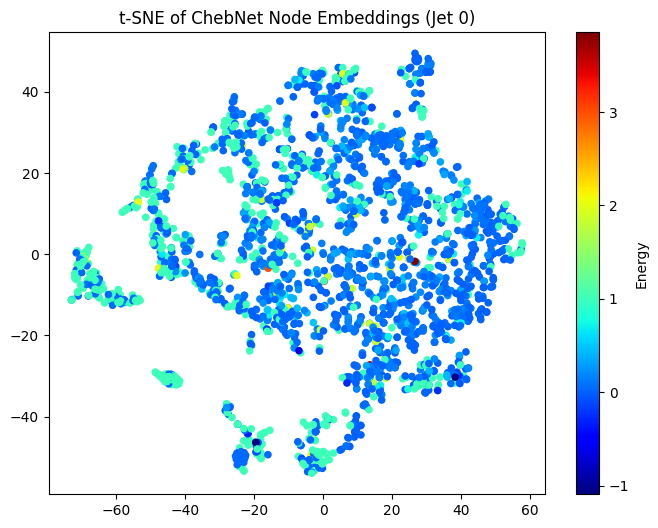


Processing jet 1...
Found 2325 hits
Node embeddings shape for jet 1: (2325, 16)
Embeddings saved to /content/jet1_node_embeddings.npy


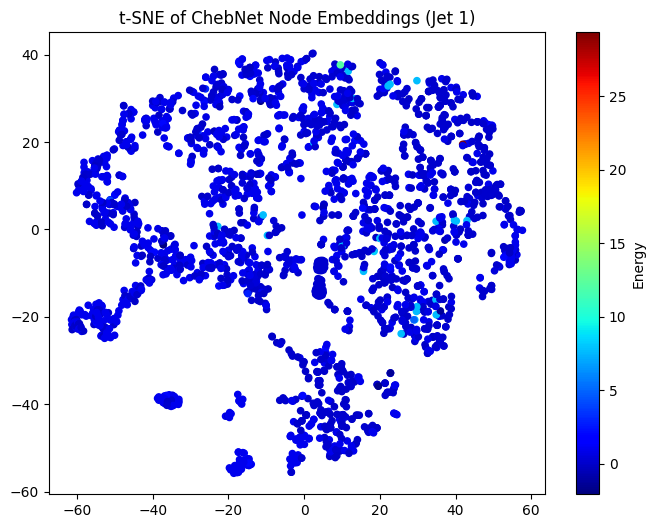


Processing jet 2...
Found 1722 hits
Node embeddings shape for jet 2: (1722, 16)
Embeddings saved to /content/jet2_node_embeddings.npy


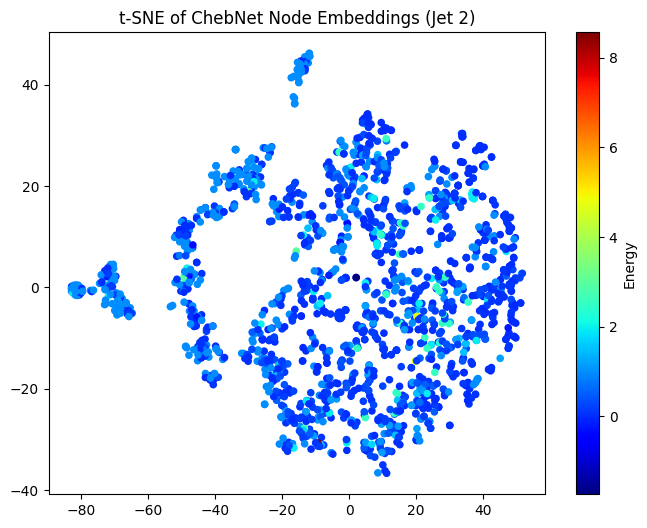

In [3]:
# --- Install dependencies (Colab only) ---
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install networkx scikit-learn pyarrow pandas

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt

# --- 1. Load and prepare your graph data ---
file_path = '/content/BoostedTop_x1_fixed_0.snappy.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')
print("Data loaded!")

jets = [df['X_jets'][0], df['X_jets'][1], df['X_jets'][2]]
reshaped_jets = [jet.reshape((125,1000)) for jet in jets]

def get_hits(jet_array):
    indices = np.nonzero(jet_array)
    x = indices[0]
    y = indices[1]
    energy = jet_array[indices]
    hits = np.vstack((x, y, energy)).T
    print(f"Found {len(hits)} hits")
    return hits

def make_graph(hits):
    coords = hits[:, :2]
    adj_matrix = kneighbors_graph(coords, n_neighbors=4, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(adj_matrix)
    return G, hits, adj_matrix

# --- 2. Define ChebNet (input dim = 3) ---
class SimpleChebNet(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=32, K=3, out_dim=16):
        super().__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K)
        self.conv3 = ChebConv(hidden_dim, out_dim, K)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(F.leaky_relu(x))
        x = self.conv2(x, edge_index)
        x = self.bn2(F.leaky_relu(x))
        x = self.conv3(x, edge_index)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleChebNet(in_dim=3, hidden_dim=32, K=3, out_dim=16).to(device)
model.eval()  # No training, just feature extraction

# --- 3. Process all jets ---
for i, jet in enumerate(reshaped_jets):
    print(f"\nProcessing jet {i}...")
    hits = get_hits(jet)
    if hits is None or len(hits) == 0:
        print(f"No hits for jet {i}")
        continue
    G, hits, adj_matrix = make_graph(hits)
    # Node features: [x, y, energy]
    x = torch.tensor(hits, dtype=torch.float)
    # Edge index: from adjacency matrix
    edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    # Run ChebNet
    with torch.no_grad():
        node_embeddings = model(data.x.to(device), data.edge_index.to(device))
        node_embeddings = node_embeddings.cpu().numpy()
    print(f"Node embeddings shape for jet {i}:", node_embeddings.shape)
    # Save embeddings
    np.save(f'/content/jet{i}_node_embeddings.npy', node_embeddings)
    print(f"Embeddings saved to /content/jet{i}_node_embeddings.npy")
    # (Optional) Visualize embeddings
    try:
        from sklearn.manifold import TSNE
        emb2d = TSNE(n_components=2).fit_transform(node_embeddings)
        plt.figure(figsize=(8,6))
        plt.scatter(emb2d[:,0], emb2d[:,1], c=hits[:,2], cmap='jet', s=20)
        plt.colorbar(label='Energy')
        plt.title(f't-SNE of ChebNet Node Embeddings (Jet {i})')
        plt.show()
    except Exception as e:
        print("t-SNE visualization skipped:", e)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleDiffusionMLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim)
        )
    def forward(self, x, t):
        # x: [batch, emb_dim], t: [batch, 1]
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# Training loop (simplified, not full DDPM)
def train_diffusion_model(embeddings, n_steps=1000, epochs=100, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    emb_dim = embeddings.shape[1]
    model = SimpleDiffusionMLP(emb_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    embeddings = torch.tensor(embeddings, dtype=torch.float32).to(device)
    for epoch in range(epochs):
        idx = torch.randperm(len(embeddings))
        for i in range(0, len(embeddings), batch_size):
            batch = embeddings[idx[i:i+batch_size]]
            t = torch.rand((batch.size(0), 1), device=device)
            noise = torch.randn_like(batch)
            noisy = batch + noise * t  # simple noise schedule
            pred_noise = model(noisy, t)
            loss = ((pred_noise - noise)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return model

# To sample new embeddings:
def sample_diffusion_model(model, emb_dim, n_samples=10, n_steps=50):
    device = next(model.parameters()).device
    x = torch.randn((n_samples, emb_dim), device=device)
    for step in reversed(range(n_steps)):
        t = torch.full((n_samples, 1), step/n_steps, device=device)
        noise_pred = model(x, t)
        x = x - noise_pred * 0.1  # simple Euler step
    return x.detach().cpu().numpy()

In [5]:
class DecoderMLP(nn.Module):
    def __init__(self, emb_dim, grid_shape, hidden_dim=128):
        super().__init__()
        self.grid_shape = grid_shape
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, grid_shape[0]*grid_shape[1])
        )
    def forward(self, z):
        out = self.net(z)
        return out.view(-1, *self.grid_shape)

# Training loop
def train_decoder(pooled_embeddings, jets, grid_shape, epochs=100, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DecoderMLP(pooled_embeddings.shape[1], grid_shape).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    pooled_embeddings = torch.tensor(pooled_embeddings, dtype=torch.float32).to(device)
    jets = torch.tensor(jets, dtype=torch.float32).to(device)
    for epoch in range(epochs):
        idx = torch.randperm(len(pooled_embeddings))
        for i in range(0, len(pooled_embeddings), batch_size):
            z = pooled_embeddings[idx[i:i+batch_size]]
            target = jets[idx[i:i+batch_size]]
            pred = model(z)
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Decoder Epoch {epoch}, Loss: {loss.item():.4f}")
    return model

Found 2453 hits
Found 2325 hits
Found 1722 hits
Epoch 0, Loss: 1.0664
Epoch 10, Loss: 1.0043
Epoch 20, Loss: 1.0661
Epoch 30, Loss: 0.8823
Epoch 40, Loss: 0.9488
Epoch 50, Loss: 0.7834
Epoch 60, Loss: 1.0385
Epoch 70, Loss: 0.6792
Epoch 80, Loss: 1.0832
Epoch 90, Loss: 0.7259
Decoder Epoch 0, Loss: 0.0184
Decoder Epoch 10, Loss: 0.0155
Decoder Epoch 20, Loss: 0.0137
Decoder Epoch 30, Loss: 0.0126
Decoder Epoch 40, Loss: 0.0116
Decoder Epoch 50, Loss: 0.0110
Decoder Epoch 60, Loss: 0.0103
Decoder Epoch 70, Loss: 0.0094
Decoder Epoch 80, Loss: 0.0086
Decoder Epoch 90, Loss: 0.0079


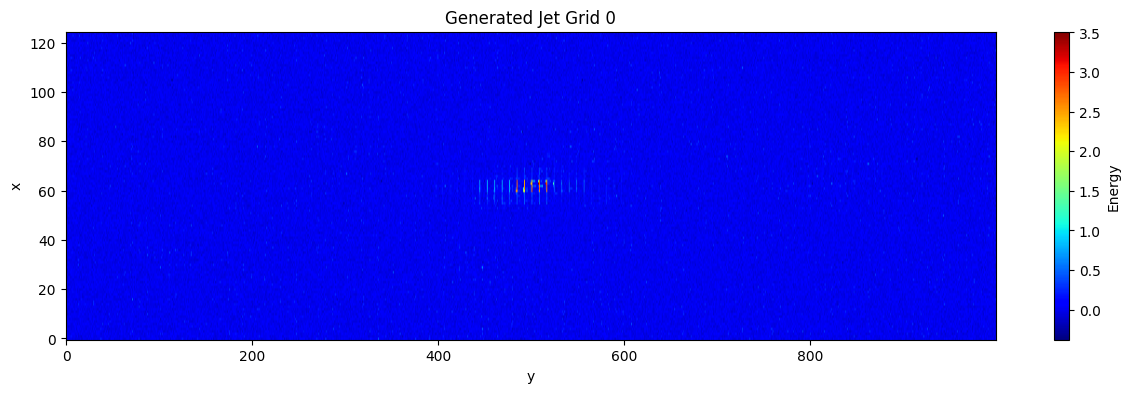

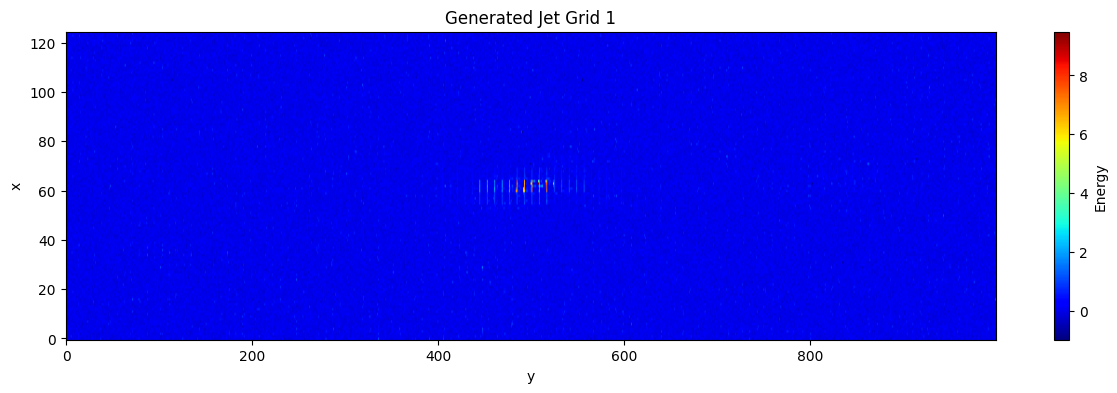

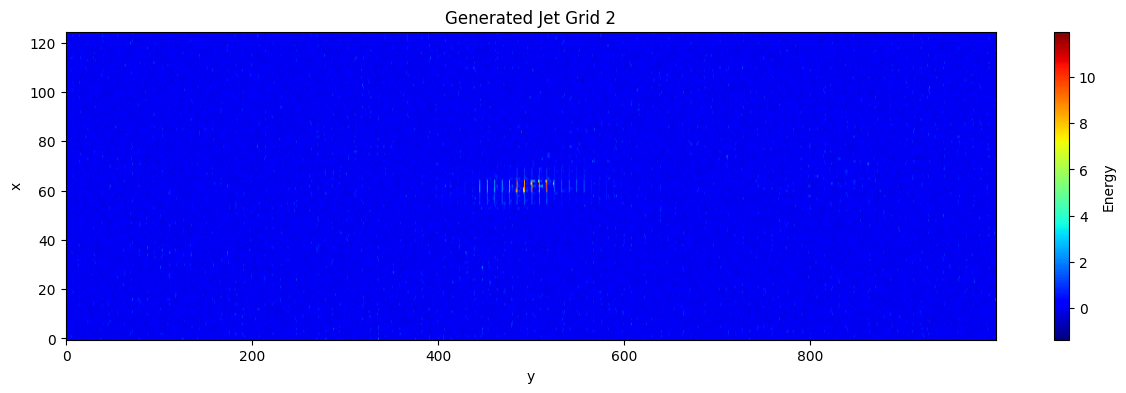

In [8]:
all_pooled_embeddings = []
all_jets = []
for jet in reshaped_jets:
    hits = get_hits(jet)
    if hits is None or len(hits) == 0:
        continue
    G, hits, adj_matrix = make_graph(hits)
    x = torch.tensor(hits, dtype=torch.float)
    edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    with torch.no_grad():
        node_embeddings = model(data.x.to(device), data.edge_index.to(device))
        node_embeddings = node_embeddings.cpu().numpy()
    pooled_embedding = node_embeddings.mean(axis=0)
    all_pooled_embeddings.append(pooled_embedding)
    all_jets.append(jet)  # shape (125, 1000)
all_pooled_embeddings = np.stack(all_pooled_embeddings)
all_jets = np.stack(all_jets)

# 2. Train diffusion model
diff_model = train_diffusion_model(all_pooled_embeddings, epochs=100)

# 3. Train decoder
decoder = train_decoder(all_pooled_embeddings, all_jets, grid_shape=(125, 1000), epochs=100)

# 4. Generate new embeddings and decode
new_embeddings = sample_diffusion_model(diff_model, emb_dim=all_pooled_embeddings.shape[1], n_samples=3)
with torch.no_grad():
    new_embeddings_torch = torch.tensor(new_embeddings, dtype=torch.float32).to(device)
    generated_grids = decoder(new_embeddings_torch).cpu().numpy()
for i, grid in enumerate(generated_grids):
    plt.figure(figsize=(15, 4))
    plt.imshow(grid, aspect='auto', origin='lower', cmap='jet')
    plt.colorbar(label='Energy')
    plt.title(f'Generated Jet Grid {i}')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.show()